<b><font color="SteelBlue" size="+3">Implémentez un modèle de scoring</font></b>

# Introduction

## Contexte et objectifs

Ce notebook a pour objectif de développer un modèle de scoring de crédit pour "Prêt à dépenser", une entreprise spécialisée dans les crédits à la consommation pour les individus avec peu ou pas d'historique de crédit. Le modèle prédira la probabilité de défaut de paiement des clients et classera les demandes de crédit en accordées ou refusées. Pour ce faire, nous utiliserons diverses sources de données, incluant des données comportementales et des informations provenant d'autres institutions financières. Le processus comprendra l'exploration des données (EDA), le prétraitement, et l'ingénierie des caractéristiques pour améliorer la performance du modèle. En intégrant des techniques de MLOps, nous assurerons la traçabilité des expérimentations et le déploiement continu du modèle, tout en prenant en compte le déséquilibre des classes et des coûts métiers associés aux erreurs de prédiction.

## Imports

In [1]:
# Chargement des librairies
# Builtin
import os

# Data
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## Data

### Structure des données

The structure of the data is explained in the following image (from the data description on the competition page)

<img src="https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png" width="800"></img>

The dataframe *application_train* and *application_test* contains the loan and loan applicants. The dataframe *bureau* contains the application data from other loans that the client took from other credit institutions and were reported to the credit bureau. The dataframe *previous_applications* contains information about previous loans at **Home Credit** by the same client, previous loans information and client information at the time of the loan (there is a line in the dataframe per previous loan application).

**SK_ID_CURR** is connecting the dataframes *application_train*|*test* with *bureau*, *previous_application* and also with dataframes *POS_CASH_balance*, *installments_payment* and *credit_card_balance*. **SK_ID_PREV** connects dataframe *previous_application* with *POS_CASH_balance*, *installments_payment* and *credit_card_balance*. **SK_ID_BUREAU** connects dataframe *bureau* with dataframe *bureau_balance*.

### Chargement des données

In [2]:
os.listdir("data/sources/")

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'Projet+Mise+en+prod+-+home-credit-default-risk.zip',
 'sample_submission.csv']

In [3]:
PATH = "./data/sources/"

In [4]:
application_train = pd.read_csv(PATH+"/application_train.csv")
application_test = pd.read_csv(PATH+"/application_test.csv")
bureau = pd.read_csv(PATH+"/bureau.csv")
bureau_balance = pd.read_csv(PATH+"/bureau_balance.csv")
credit_card_balance = pd.read_csv(PATH+"/credit_card_balance.csv")
installments_payments = pd.read_csv(PATH+"/installments_payments.csv")
previous_application = pd.read_csv(PATH+"/previous_application.csv")
POS_CASH_balance = pd.read_csv(PATH+"/POS_CASH_balance.csv")

### Quick tour

In [5]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

#### Taille des données

In [6]:
print("application_train -  rows:",application_train.shape[0]," columns:", application_train.shape[1])
print("application_test -  rows:",application_test.shape[0]," columns:", application_test.shape[1])
print("bureau -  rows:",bureau.shape[0]," columns:", bureau.shape[1])
print("bureau_balance -  rows:",bureau_balance.shape[0]," columns:", bureau_balance.shape[1])
print("credit_card_balance -  rows:",credit_card_balance.shape[0]," columns:", credit_card_balance.shape[1])
print("installments_payments -  rows:",installments_payments.shape[0]," columns:", installments_payments.shape[1])
print("previous_application -  rows:",previous_application.shape[0]," columns:", previous_application.shape[1])
print("POS_CASH_balance -  rows:",POS_CASH_balance.shape[0]," columns:", POS_CASH_balance.shape[1])

application_train -  rows: 307511  columns: 122
application_test -  rows: 48744  columns: 121
bureau -  rows: 1716428  columns: 17
bureau_balance -  rows: 27299925  columns: 3
credit_card_balance -  rows: 3840312  columns: 23
installments_payments -  rows: 13605401  columns: 8
previous_application -  rows: 1670214  columns: 37
POS_CASH_balance -  rows: 10001358  columns: 8


#### application_train

In [7]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
application_train.columns.values

array(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3',

In [9]:
missing_data(application_train).head(10)

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953


#### application_test

In [10]:
application_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
application_test.columns.values

array(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG'

In [12]:
missing_data(application_test).head(10)

,Total,Percent
COMMONAREA_AVG,33495,68.716150
COMMONAREA_MODE,33495,68.716150
COMMONAREA_MEDI,33495,68.716150
NONLIVINGAPARTMENTS_AVG,33347,68.412523
NONLIVINGAPARTMENTS_MODE,33347,68.412523
NONLIVINGAPARTMENTS_MEDI,33347,68.412523
FONDKAPREMONT_MODE,32797,67.284179
LIVINGAPARTMENTS_AVG,32780,67.249302
LIVINGAPARTMENTS_MODE,32780,67.249302
LIVINGAPARTMENTS_MEDI,32780,67.249302


#### bureau

In [13]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [14]:
bureau.columns.values

array(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
       'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
       'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE',
       'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY'], dtype=object)

In [15]:
missing_data(bureau)

,Total,Percent
AMT_ANNUITY,1226791,71.473490
AMT_CREDIT_MAX_OVERDUE,1124488,65.513264
DAYS_ENDDATE_FACT,633653,36.916958
AMT_CREDIT_SUM_LIMIT,591780,34.477415
AMT_CREDIT_SUM_DEBT,257669,15.011932
DAYS_CREDIT_ENDDATE,105553,6.149573
AMT_CREDIT_SUM,13,0.000757
CREDIT_ACTIVE,0,0.000000
CREDIT_CURRENCY,0,0.000000
DAYS_CREDIT,0,0.000000


#### bureau_balance

In [16]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [17]:
missing_data(bureau_balance)

,Total,Percent
SK_ID_BUREAU,0,0.0
MONTHS_BALANCE,0,0.0
STATUS,0,0.0


#### credit_card_balance

In [18]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [19]:
credit_card_balance.columns.values

array(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE',
       'AMT_TOTAL_RECEIVABLE', 'CNT_DRAWINGS_ATM_CURRENT',
       'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT',
       'CNT_DRAWINGS_POS_CURRENT', 'CNT_INSTALMENT_MATURE_CUM',
       'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF'], dtype=object)

In [20]:
missing_data(credit_card_balance)

,Total,Percent
AMT_PAYMENT_CURRENT,767988,19.998063
AMT_DRAWINGS_ATM_CURRENT,749816,19.524872
CNT_DRAWINGS_POS_CURRENT,749816,19.524872
AMT_DRAWINGS_OTHER_CURRENT,749816,19.524872
AMT_DRAWINGS_POS_CURRENT,749816,19.524872
CNT_DRAWINGS_OTHER_CURRENT,749816,19.524872
CNT_DRAWINGS_ATM_CURRENT,749816,19.524872
CNT_INSTALMENT_MATURE_CUM,305236,7.948208
AMT_INST_MIN_REGULARITY,305236,7.948208
SK_ID_PREV,0,0.000000


#### installments_payments

In [21]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [22]:
installments_payments.columns.values

array(['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT'], dtype=object)

In [23]:
missing_data(installments_payments)

,Total,Percent
DAYS_ENTRY_PAYMENT,2905,0.021352
AMT_PAYMENT,2905,0.021352
SK_ID_PREV,0,0.000000
SK_ID_CURR,0,0.000000
NUM_INSTALMENT_VERSION,0,0.000000
NUM_INSTALMENT_NUMBER,0,0.000000
DAYS_INSTALMENT,0,0.000000
AMT_INSTALMENT,0,0.000000


#### previous_applications

In [24]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
previous_application.columns.values

array(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT',
       'AMT_GOODS_PRICE', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT',
       'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT',
       'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED',
       'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'DAYS_DECISION',
       'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE',
       'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO',
       'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'SELLERPLACE_AREA',
       'NAME_SELLER_INDUSTRY', 'CNT_PAYMENT', 'NAME_YIELD_GROUP',
       'PRODUCT_COMBINATION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
       'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION',
       'NFLAG_INSURED_ON_APPROVAL'], dtype=object)

In [26]:
missing_data(previous_application).head(20)

,Total,Percent
RATE_INTEREST_PRIVILEGED,1664263,99.643698
RATE_INTEREST_PRIMARY,1664263,99.643698
AMT_DOWN_PAYMENT,895844,53.636480
RATE_DOWN_PAYMENT,895844,53.636480
NAME_TYPE_SUITE,820405,49.119754
NFLAG_INSURED_ON_APPROVAL,673065,40.298129
DAYS_TERMINATION,673065,40.298129
DAYS_LAST_DUE,673065,40.298129
DAYS_LAST_DUE_1ST_VERSION,673065,40.298129
DAYS_FIRST_DUE,673065,40.298129


#### POS_CASH_balance

In [27]:
POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [28]:
POS_CASH_balance.columns.values

array(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT',
       'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'], dtype=object)

In [29]:
missing_data(POS_CASH_balance)

,Total,Percent
CNT_INSTALMENT_FUTURE,26087,0.260835
CNT_INSTALMENT,26071,0.260675
SK_ID_PREV,0,0.000000
SK_ID_CURR,0,0.000000
MONTHS_BALANCE,0,0.000000
NAME_CONTRACT_STATUS,0,0.000000
SK_DPD,0,0.000000
SK_DPD_DEF,0,0.000000


### Check data unbalance

**TARGET** value 0 means loan is repayed, value 1 means loan is not repayed.

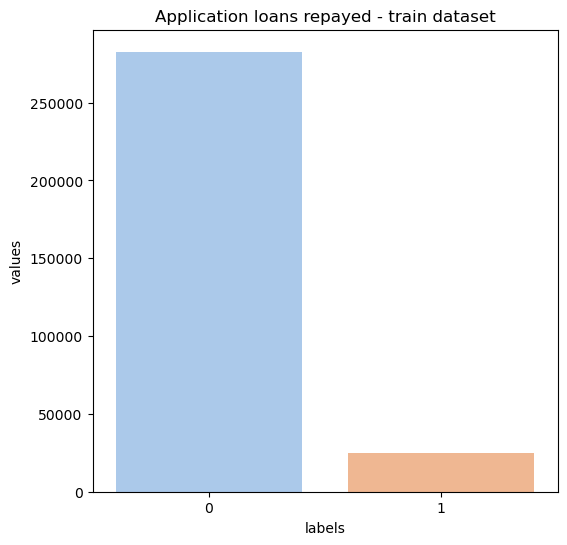

In [30]:
temp = application_train["TARGET"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
plt.figure(figsize = (6,6))
plt.title('Application loans repayed - train dataset')
palette = sns.color_palette("pastel", len(df))
sns.barplot(x = 'labels', y="values", data=df, palette=palette, hue='labels', legend =False)
locs, labels = plt.xticks()
plt.show()

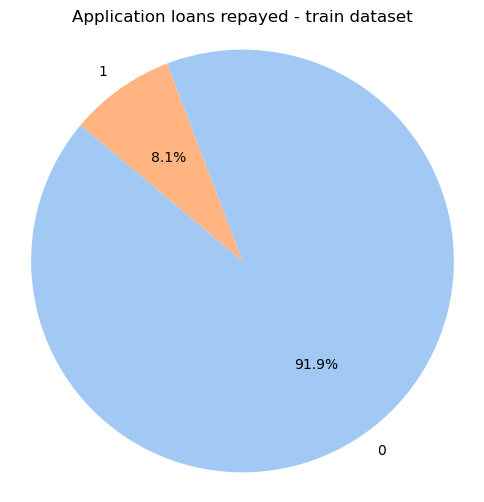

In [31]:
plt.figure(figsize=(6, 6))
plt.title('Application loans repayed - train dataset')

# Couleurs pastels pour le pie chart
palette = sns.color_palette("pastel", len(df))

# Création du pie chart
plt.pie(df['values'], labels=df['labels'], colors=palette, autopct='%1.1f%%', startangle=140)

# Affichage
plt.axis('equal')
plt.show()

# EDA

## Application data

### Loan types
    
Let's see the type of the loans taken and also, on a separate plot, the percent of the loans (by type of the loan) with **TARGET** value 1 (not returned loan).

In [32]:
def plot_stats(feature, label_rotation=False, horizontal_layout=True):
    temp = application_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index, 'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = application_train[[feature, 'TARGET']].groupby([feature], as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)

    palette = sns.color_palette("pastel", len(df1))

    if horizontal_layout:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 10))

    # Barplot for number of contracts
    sns.barplot(ax=ax1, x=feature, y="Number of contracts", data=df1, palette=palette, hue=feature, legend =False)
    if label_rotation:
        ax1.set_xticks(range(len(df1)))
        ax1.set_xticklabels(df1[feature], rotation=90)

    # Barplot for percentage of target=1
    sns.barplot(ax=ax2, x=feature, y='TARGET', order=cat_perc[feature], data=cat_perc, palette=palette, hue=feature, legend =False)
    if label_rotation:
        ax2.set_xticks(range(len(cat_perc)))
        ax2.set_xticklabels(cat_perc[feature], rotation=90)
    
    ax2.set_ylabel('Percent of target with value 1 [%]', fontsize=10)
    ax2.tick_params(axis='both', which='major', labelsize=10)

    plt.tight_layout()
    plt.show()

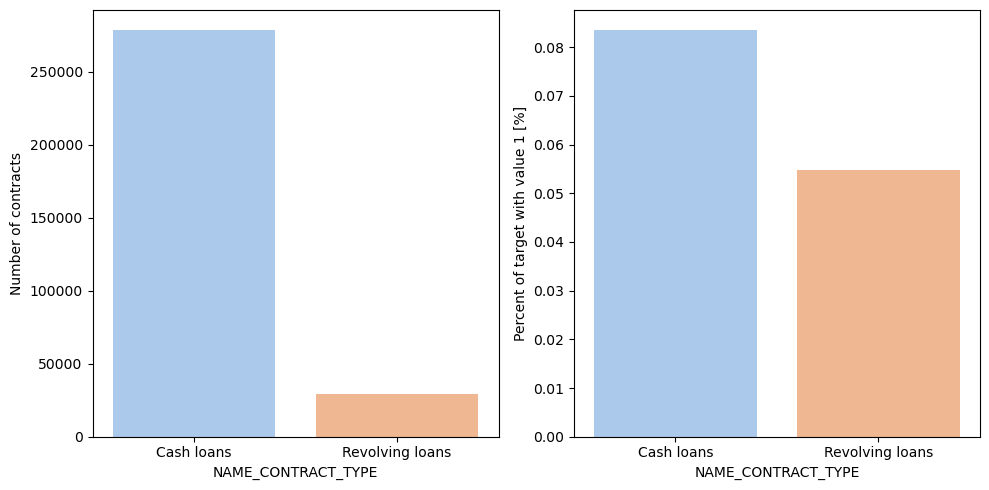

In [33]:
plot_stats('NAME_CONTRACT_TYPE')

Contract type *Revolving loans* are just a small fraction (10%) from the total number of loans; in the same time, a larger amount of *Revolving loans*, comparing with their frequency, are not repaid.

### Client gender

Let's see the gender of the clients and also, on a separate plot, the percent of the loans (by client gender) with TARGET value 1 (not returned loan).

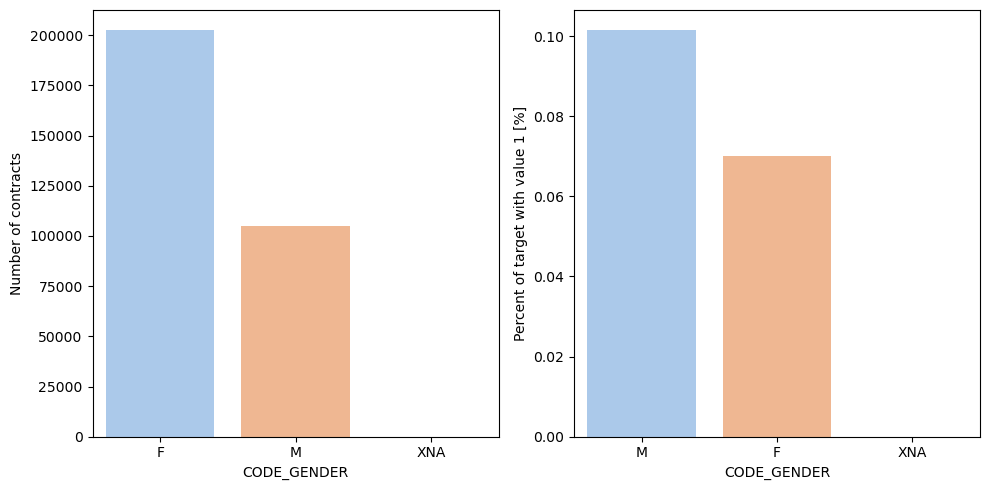

In [34]:
plot_stats('CODE_GENDER')

The number of female clients is almost double the number of male clients. Looking to the percent of defaulted credits, males have a higher chance of not returning their loans (`~10%`), comparing with women (`~7%`).

### Flag own car and flag own real estate

Let's inspect the  flags that tell us if a client owns a car or real estate and, on separate plots, the percent of the loans value of these flags) with TARGET value 1 (not returned loan).

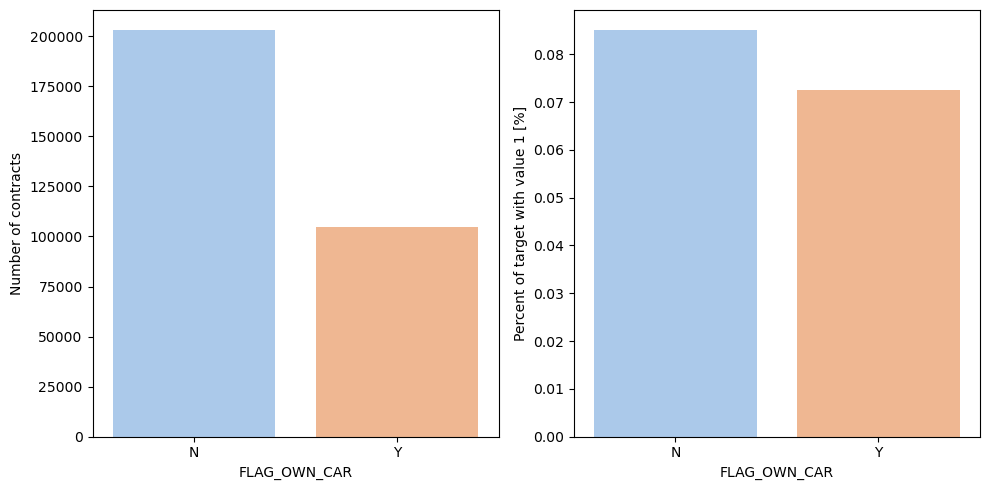

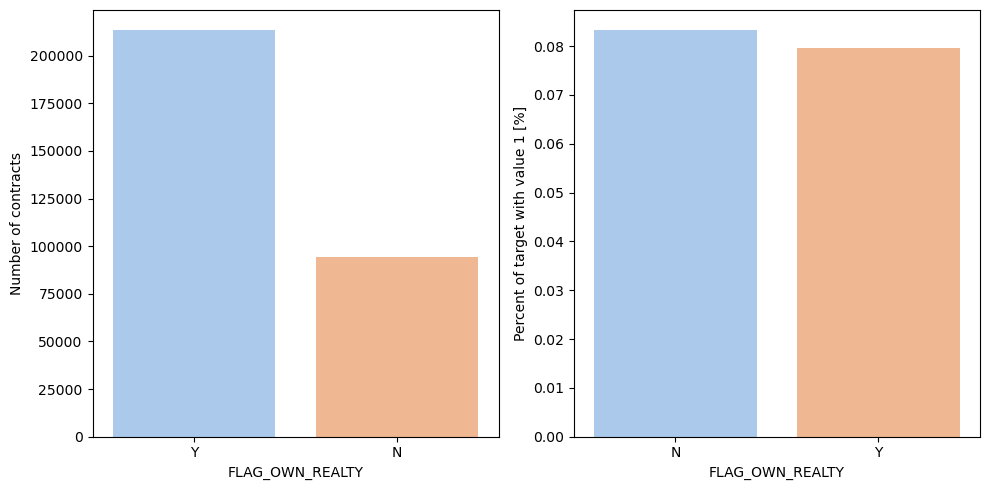

In [35]:
plot_stats('FLAG_OWN_CAR')
plot_stats('FLAG_OWN_REALTY')

The clients that owns a car are almost a half of the ones that doesn't own one. The clients that owns a car are less likely to not repay a car that the ones that own. Both categories have not-repayment rates around 8%.

The clients that owns real estate are more than double of the ones that doesn't own. Both categories (owning real estate or not owning) have not-repayment rates less than 8%.


### Family status of client

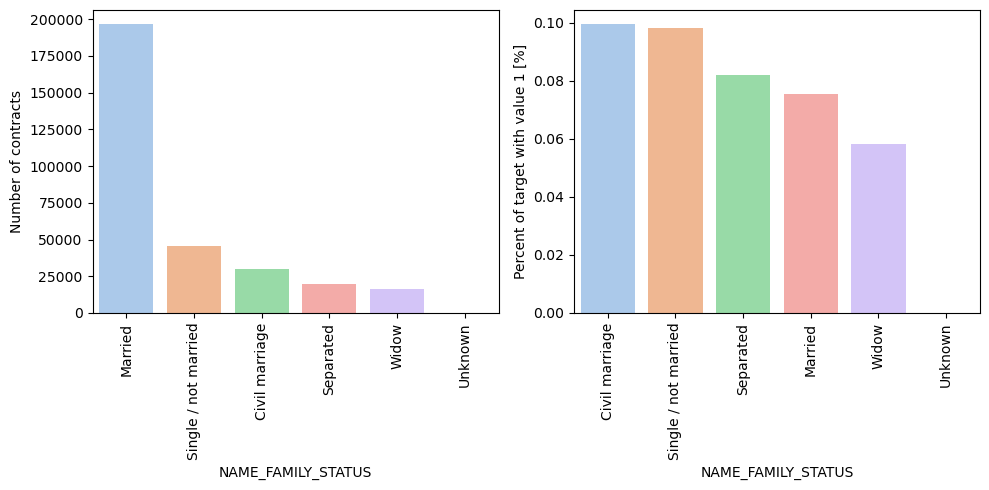

In [36]:
plot_stats('NAME_FAMILY_STATUS',True, True)

Most of clients are married, followed by Single/not married and civil marriage.

In terms of percentage of not repayment of loan, Civil marriage has the highest percent of not repayment (10%), with Widow the lowest (exception being *Unknown*).

### Number of children

Let's see what is the distribution of the number of children of the clients.

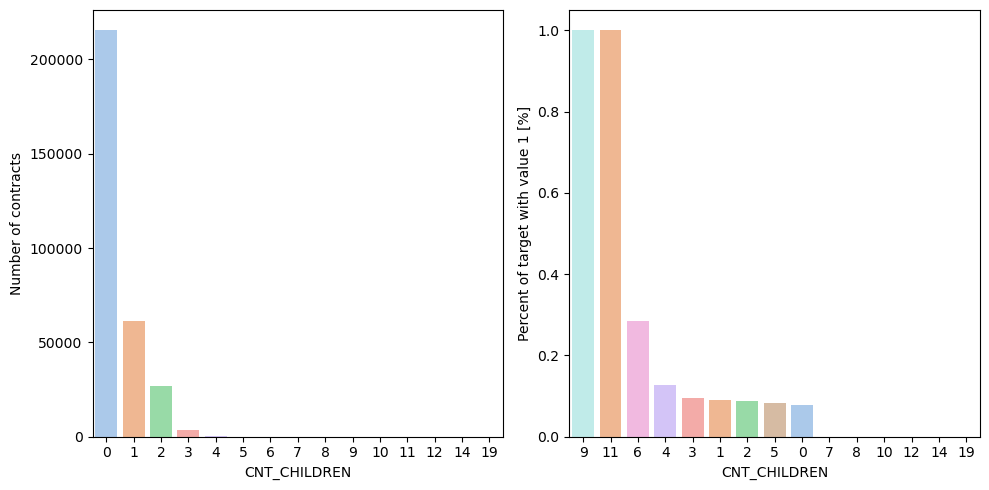

In [37]:
plot_stats('CNT_CHILDREN')

Most of the clients taking a loan have no children. The number of loans associated with the clients with one children are 4 times smaller, the number of loans associated with the clients with two children are 8 times smaller; clients with 3, 4 or more children are much more rare. 

As for repayment, clients with no children, 1, 2, 3, and 5 children have percents of no repayment around the average (10%). The clients with 4 and 6 children are above average in terms of percent of not paid back loans (over 25% for families with 6 children).

As for clients with 9 or 11 children, the percent of loans not repaid is 100%.



### Number of family members of client

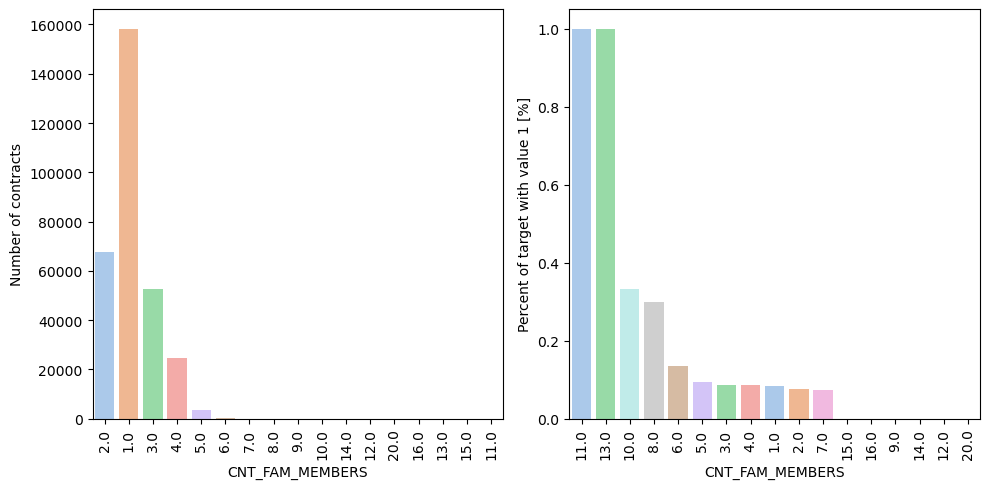

In [38]:
plot_stats('CNT_FAM_MEMBERS',True)

Clients with family members of 2 are most numerous, followed by 1 (single persons), 3 (families with one child) and 4.

Clients with family size of 11 and 13 have 100% not repayment rate. Other families with 10 or 8 members have percents of not repayment of loans over 30%. Families with 6 or less members have repayment rates close to the 10% average.


### Income type of client

Let's investigate the numbers of clients with different income type. As well, let's see the percent of not returned loans per income type of applicants.

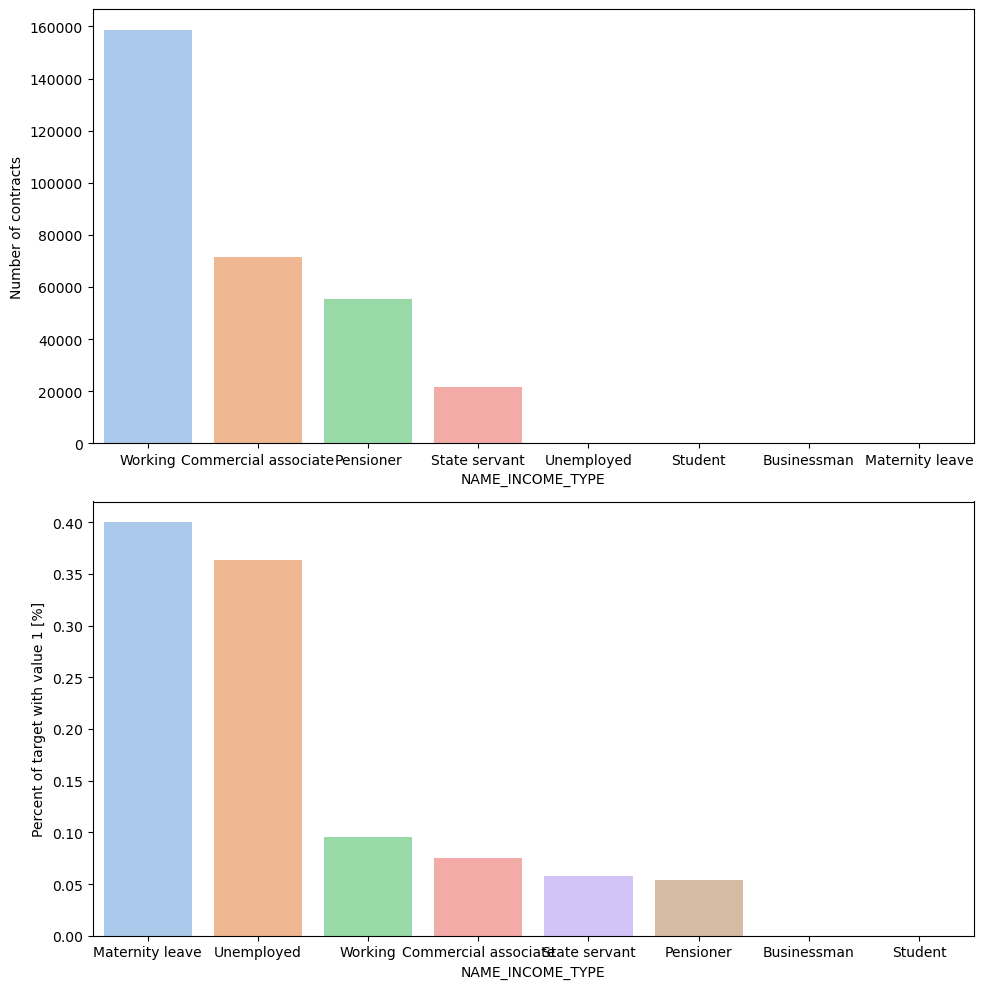

In [39]:
plot_stats('NAME_INCOME_TYPE',False,False)

Most of applicants for loans are income from *Working*, followed by *Commercial associate*, *Pensioner* and *State servant*.

The applicants with the type of income *Maternity leave* have almost 40% ratio of not returning loans, followed by *Unemployed* (37%). The rest of types of incomes are under the average of 10% for not returning loans.


### Ocupation of client



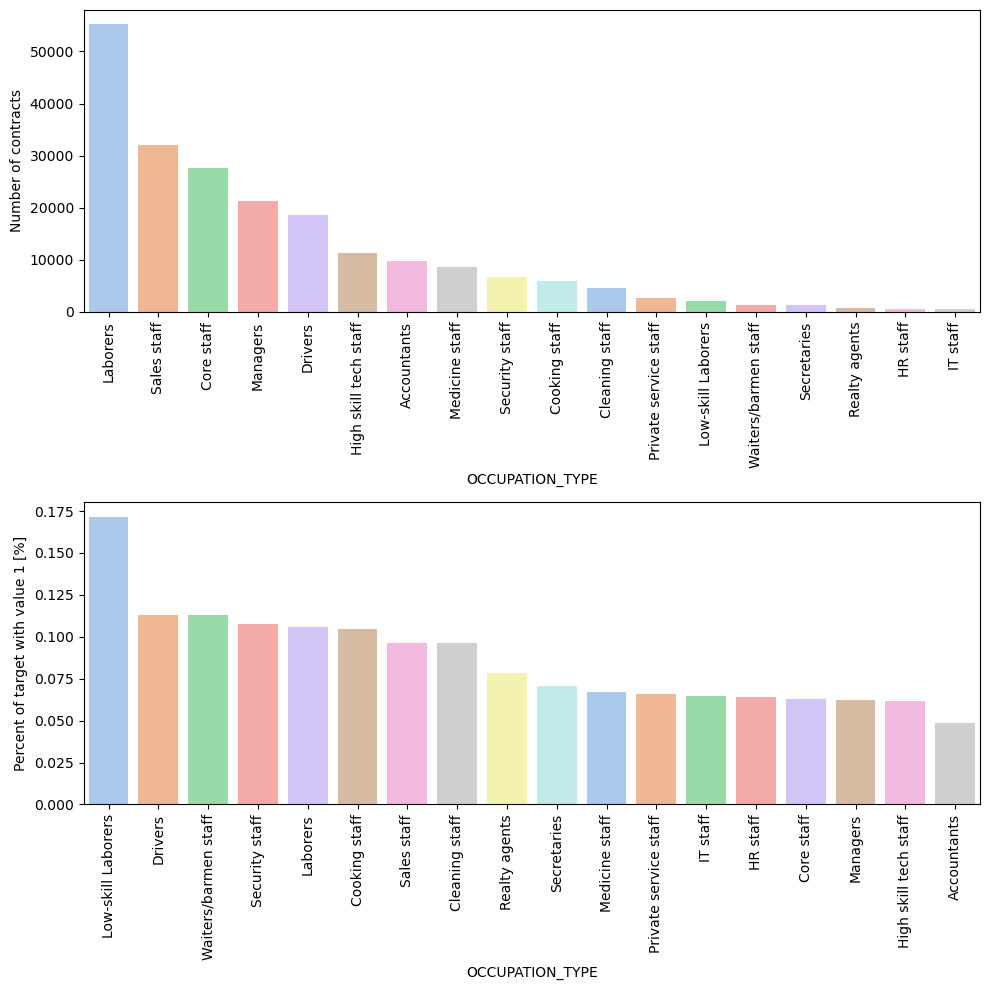

In [40]:
plot_stats('OCCUPATION_TYPE',True, False)

Most of the loans are taken by *Laborers*, followed by *Sales staff*. *IT staff* take the lowest amount of loans.

The category with highest percent of not repaid loans are *Low-skill Laborers* (above 17%), followed by *Drivers* and *Waiters/barmen staff*, *Security staff*, *Laborers* and *Cooking staff*.

### Organization type

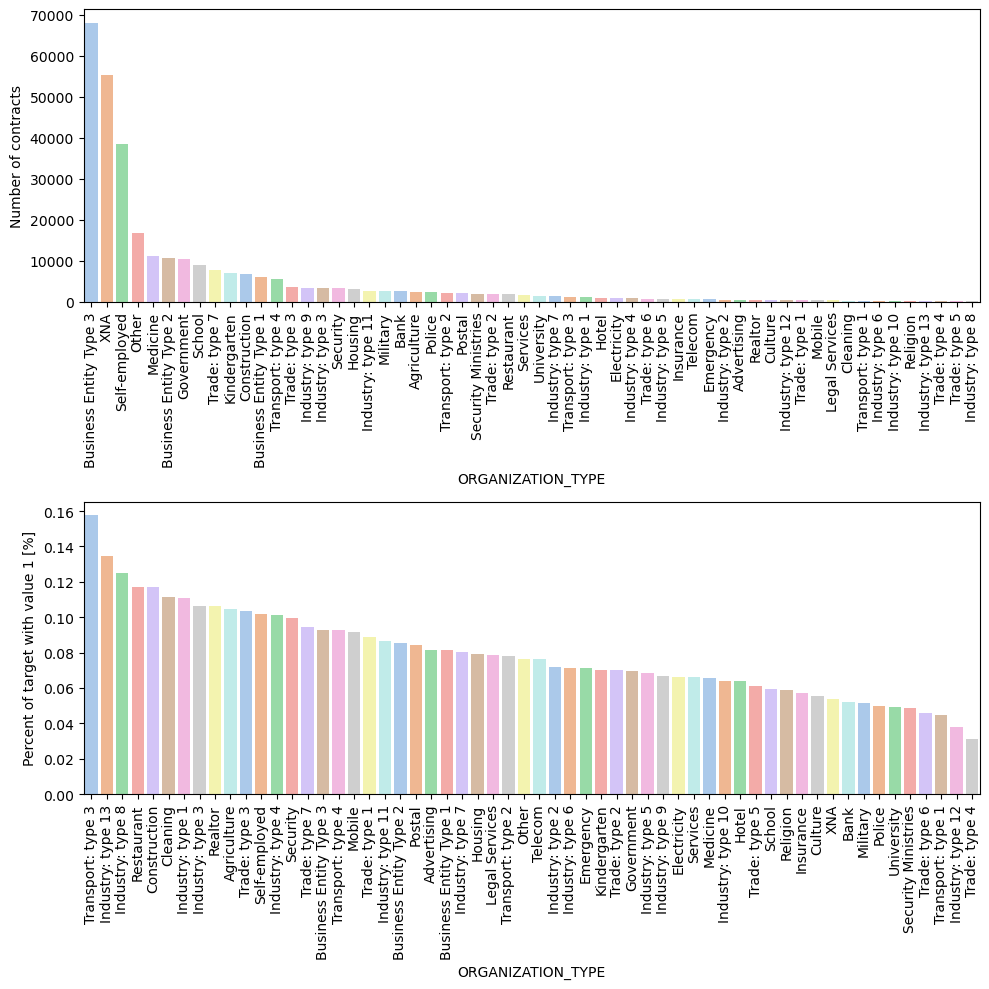

In [41]:
plot_stats('ORGANIZATION_TYPE',True, False)

Oraganizations with highest percent of loans not repaid are *Transport: type 3* (16%), *Industry: type 13* (13.5%), *Industry: type 8* (12.5%) and *Restaurant* (less than 12%).

### Education type of the client

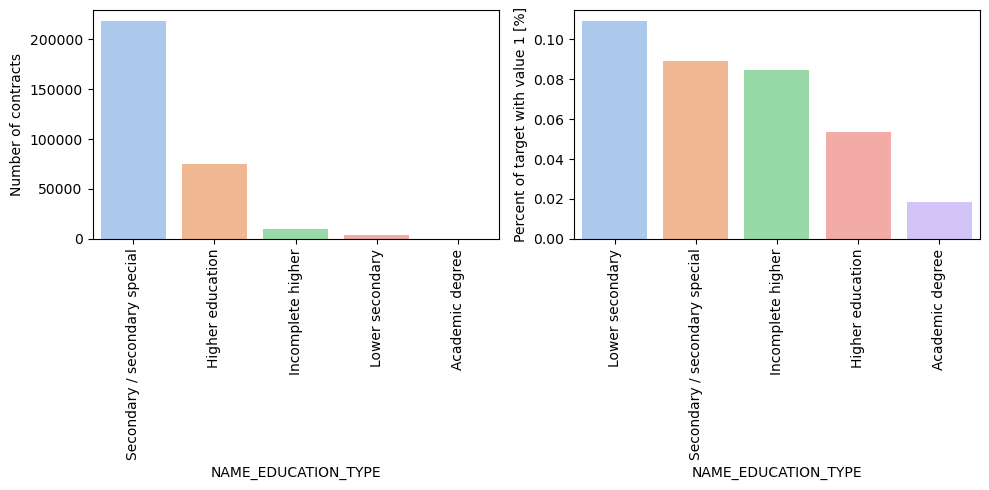

In [42]:
plot_stats('NAME_EDUCATION_TYPE',True)

Majority of the clients have Secondary / secondary special education, followed by clients with Higher education. Only a very small number having an academic degree.

The Lower secondary category, although rare, have the largest rate of not returning the loan (11%). The people with Academic degree have less than 2% not-repayment rate.


### Type of the housing of client

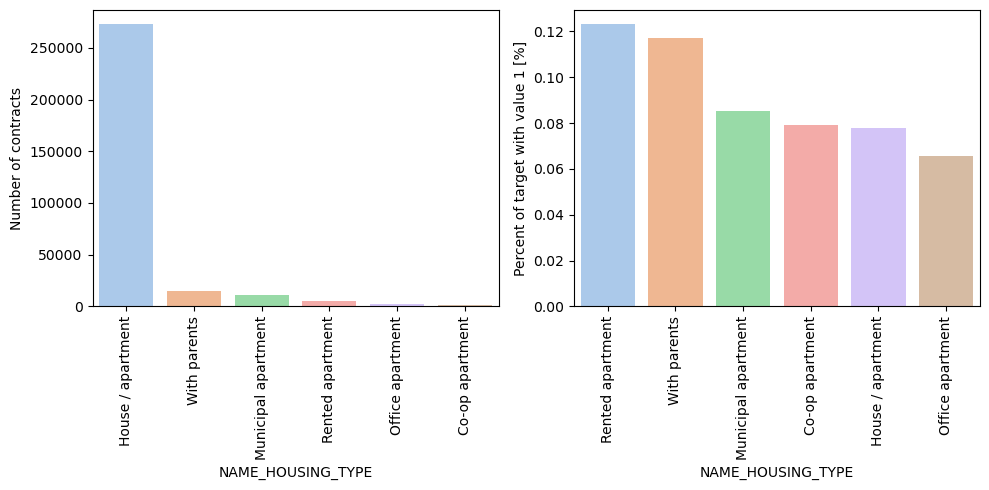

In [43]:
plot_stats('NAME_HOUSING_TYPE',True)

Over 250,000 applicants for credits registered their housing as House/apartment. Following categories have a very small number of clients (With parents, Municipal appartment).

From these categories, *Rented apartment* and *With parents* have higher than 10% not-repayment rate.

### Total income distribution

Let's plot the distribution of total income for the clients.

In [44]:
# Plot distribution of one feature
def plot_distribution(feature, color):
    plt.figure(figsize=(10, 6))
    plt.title("Distribution of %s" % feature)
    sns.histplot(application_train[feature].dropna(), color=color, kde=True, bins=100)
    plt.show() 

In [45]:
# Plot distribution of multiple features, with TARGET = 1/0 on the same graph
def plot_distribution_comp(var, nrow=2):
    
    i = 0
    t1 = application_train.loc[application_train['TARGET'] != 0]
    t0 = application_train.loc[application_train['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow, 2, figsize=(10, 3*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow, 2, i)
        sns.kdeplot(t1[feature], bw_adjust=0.5, label="TARGET = 1")
        sns.kdeplot(t0[feature], bw_adjust=0.5, label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()
    plt.show()

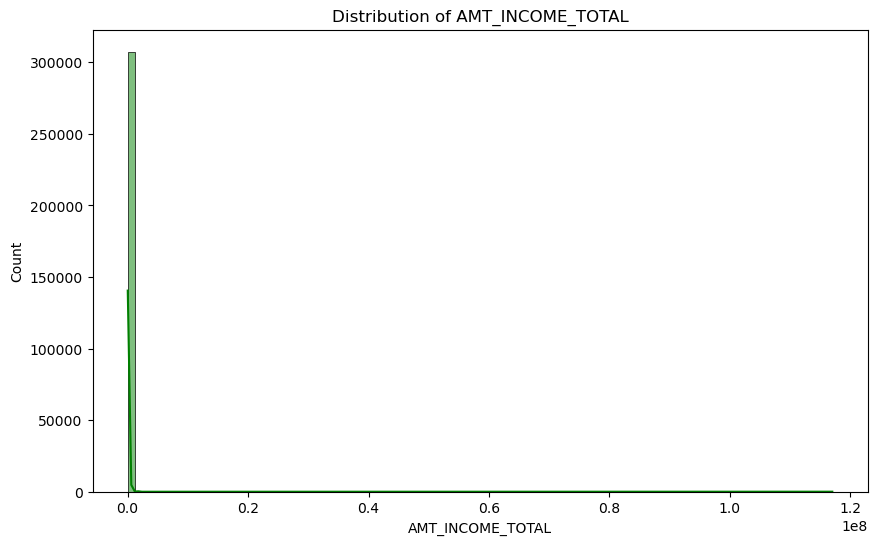

In [46]:
plot_distribution('AMT_INCOME_TOTAL','green')

### Credit distribution

Let's plot the credit distribution.

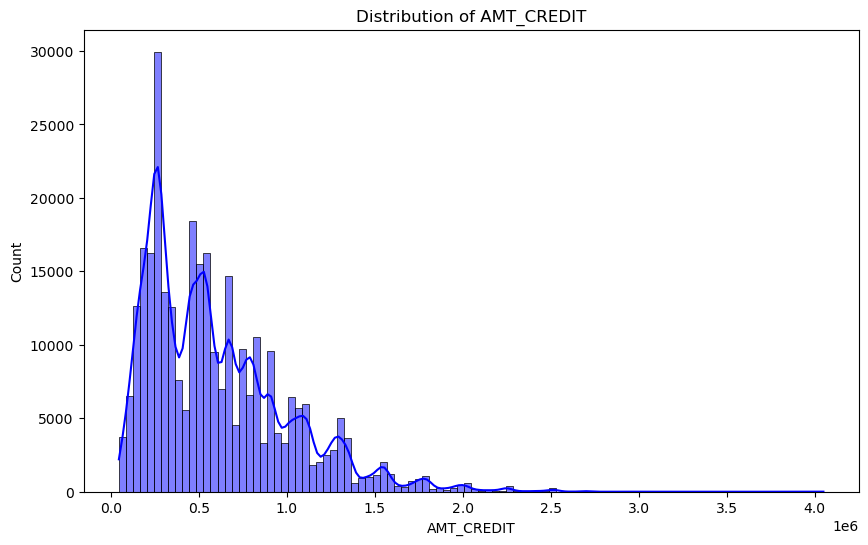

In [47]:
plot_distribution('AMT_CREDIT','blue')

### Annuity distribution

Let's plot the annuity distribution.

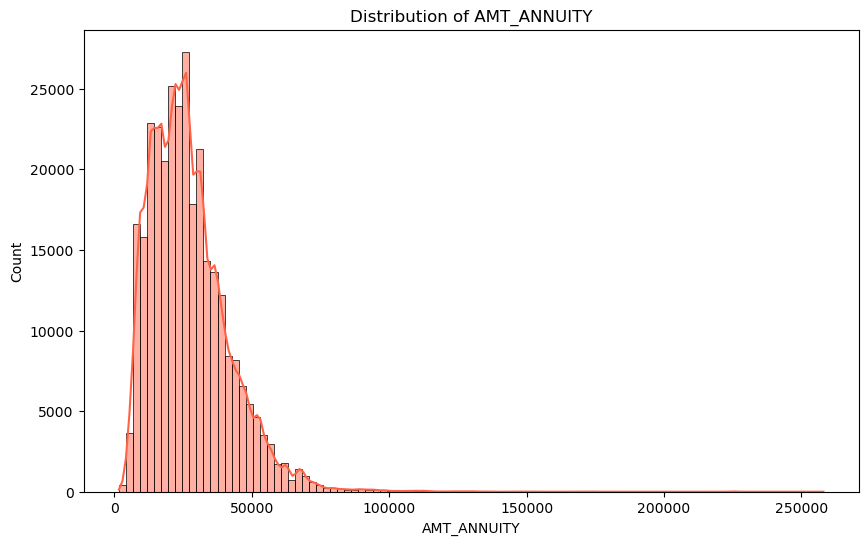

In [48]:
plot_distribution('AMT_ANNUITY','tomato')

### Goods price

Let's plot the good price distribution.

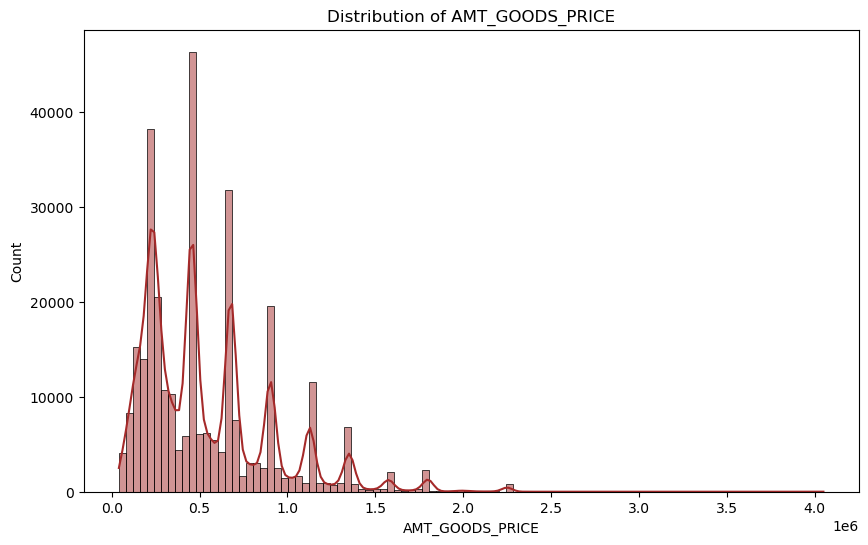

In [49]:
plot_distribution('AMT_GOODS_PRICE','brown')

### Days from birth distribution

Let's plot the distribution number of days from birth.

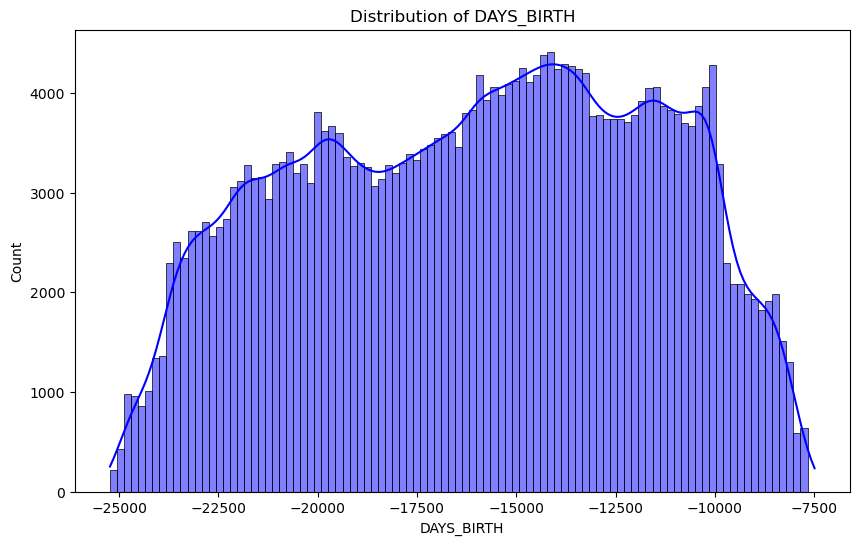

In [50]:
plot_distribution('DAYS_BIRTH','blue')

The negative value means that the date of birth is in the past. The age range is between approximative 20 and 68 years.

### Days employed distribution

Let's represent the distribution of number of days employed.

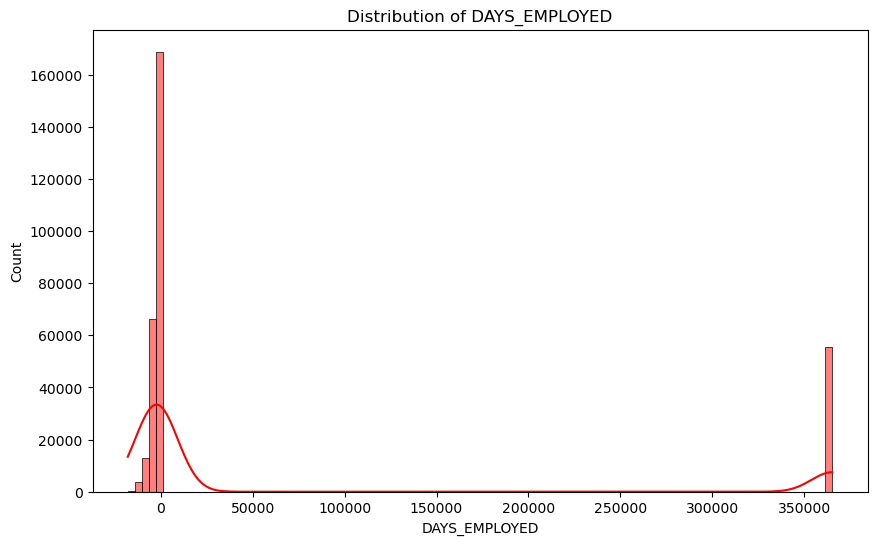

In [51]:
plot_distribution('DAYS_EMPLOYED','red')

The negative values means *Days since employed* and most probably these negative values means *Unemployed*. It is not clear what will be the meaning of the very large numbers at the far end (it is not realistic such a large set of people employed more than 100 years).


### Days of registration distribution

Let's plot the distribution of `DAYS_REGISTRATION`.

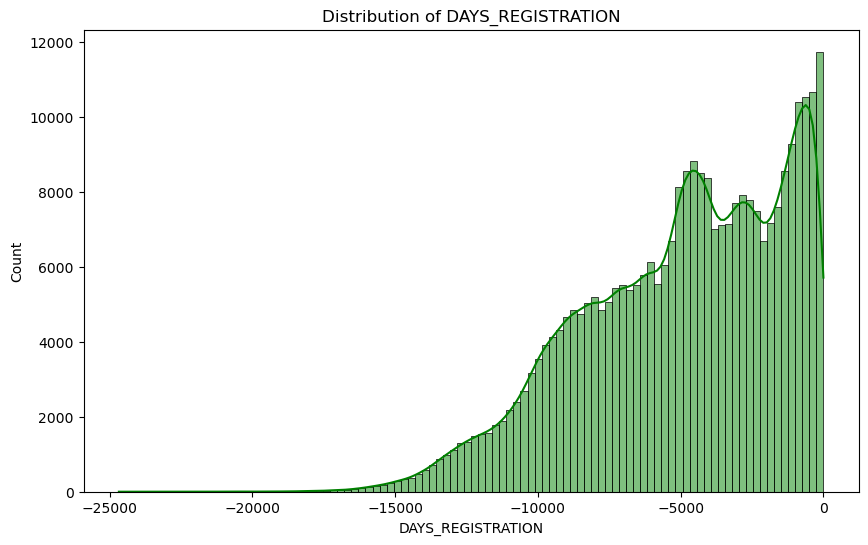

In [52]:
plot_distribution('DAYS_REGISTRATION','green')

### Days ID publish distribution

Let's plot the distribution of DAYS_ID_PUBLISH.

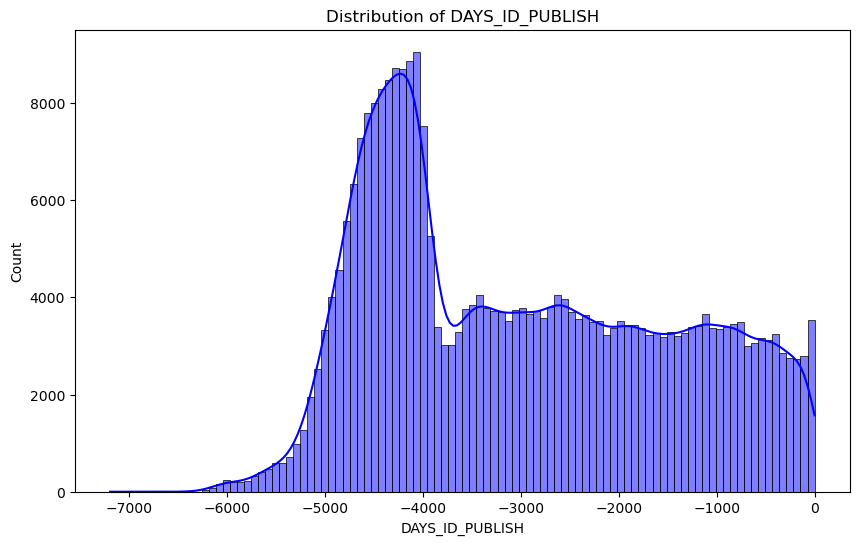

In [53]:
plot_distribution('DAYS_ID_PUBLISH','blue')

### Ext_Source

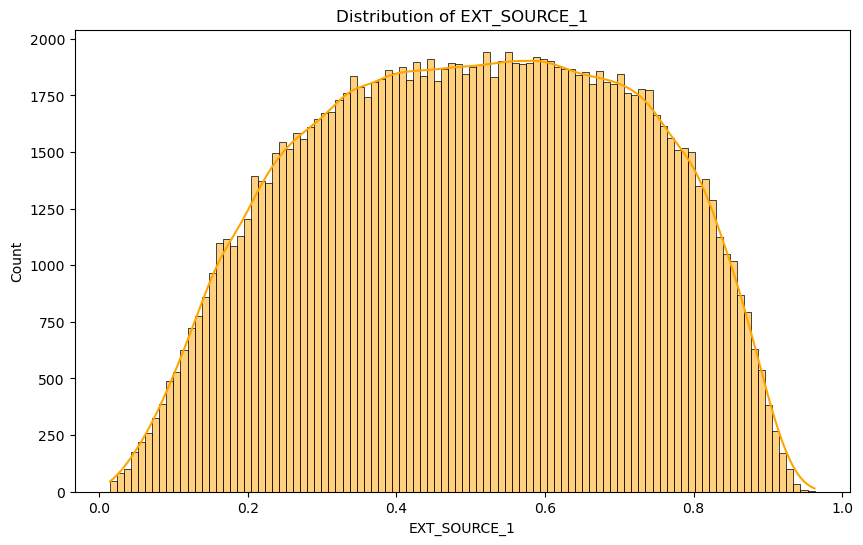

In [54]:
plot_distribution('EXT_SOURCE_1','orange')

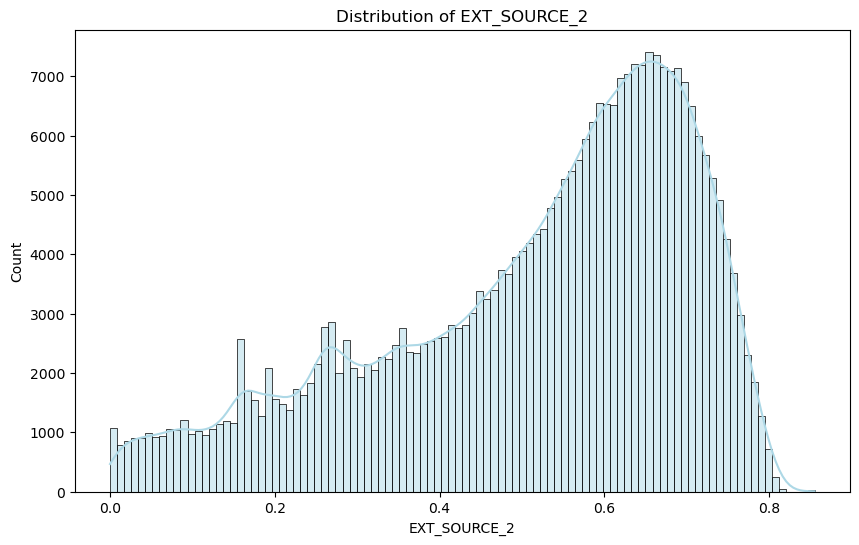

In [55]:
plot_distribution('EXT_SOURCE_2','lightblue')

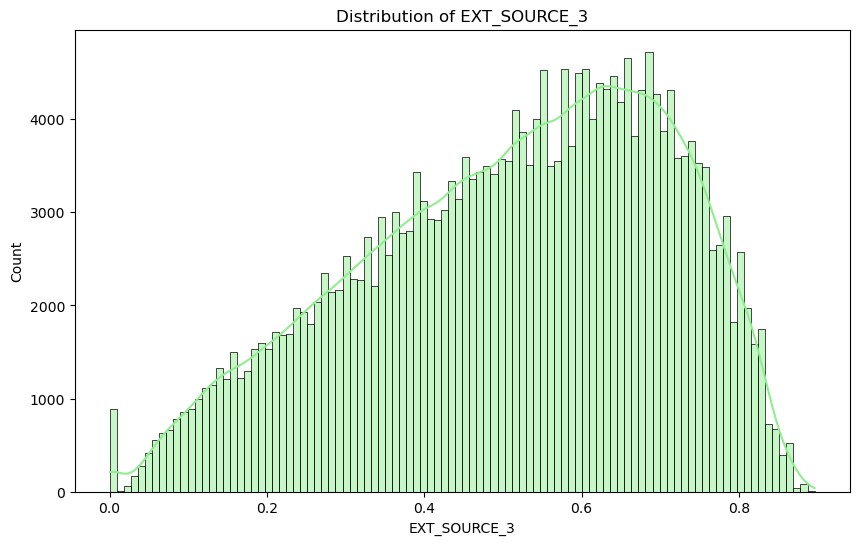

In [56]:
plot_distribution('EXT_SOURCE_3','lightgreen')

### Comparison of interval values with TARGET = 1 and TARGET = 0

Let's compare the distribution of interval values ploted above for values of **TARGET = 1** and **TARGET = 0**

<Figure size 640x480 with 0 Axes>

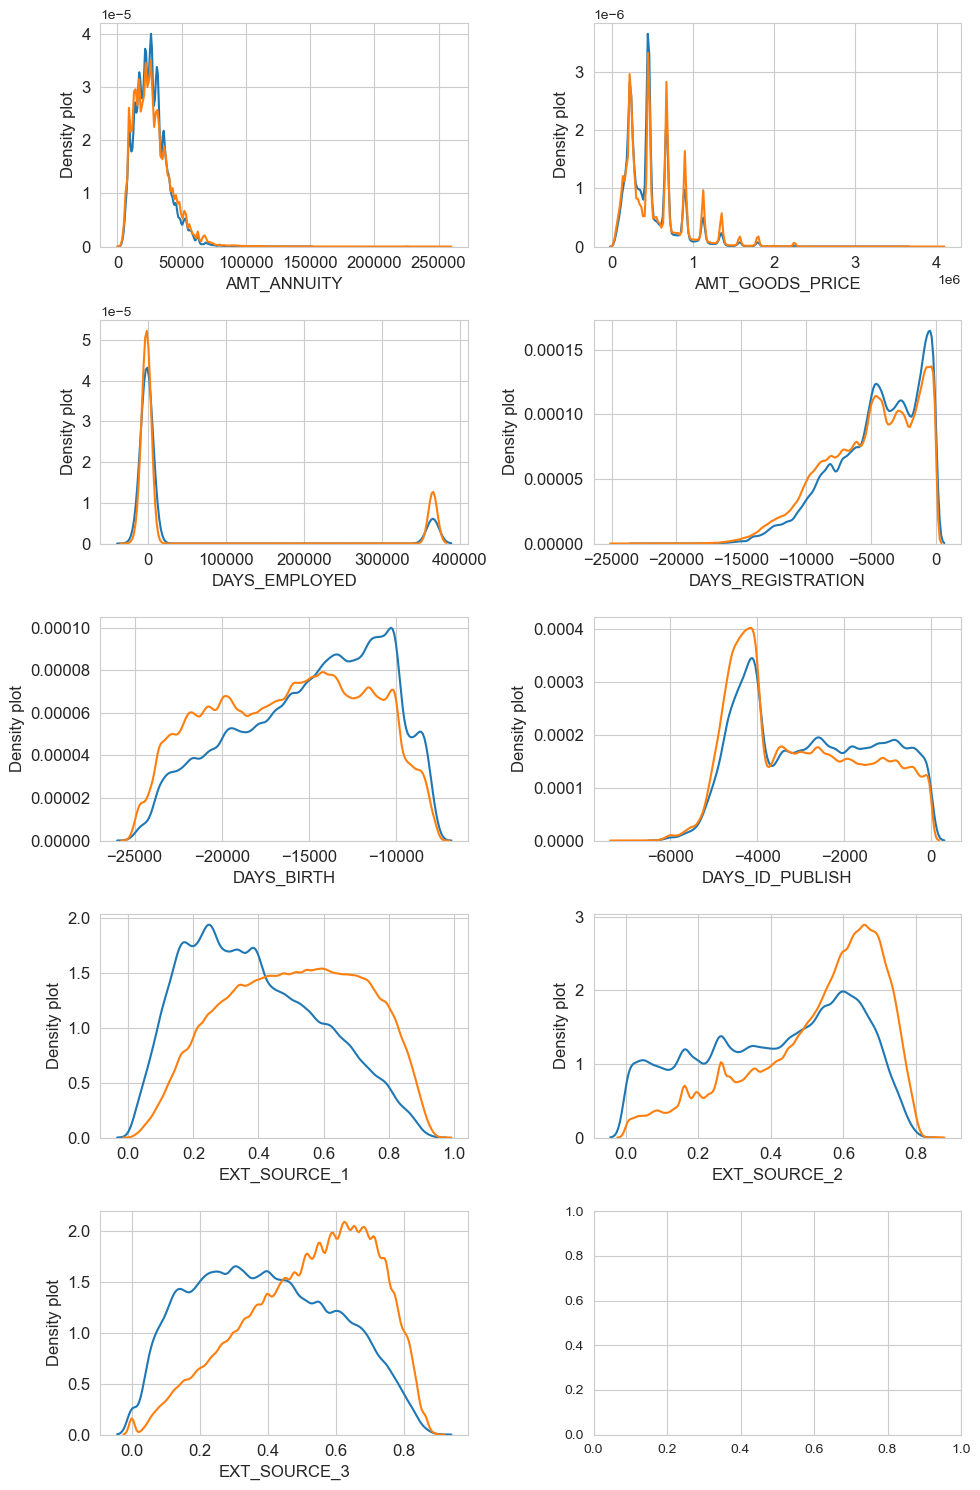

In [57]:
var = ['AMT_ANNUITY','AMT_GOODS_PRICE','DAYS_EMPLOYED', 'DAYS_REGISTRATION','DAYS_BIRTH','DAYS_ID_PUBLISH','EXT_SOURCE_1',
       'EXT_SOURCE_2','EXT_SOURCE_3']
plot_distribution_comp(var,nrow=5)

### Region registered not live region and not work region

Let's represent the values of region registered and not live region and region registered and not work region.

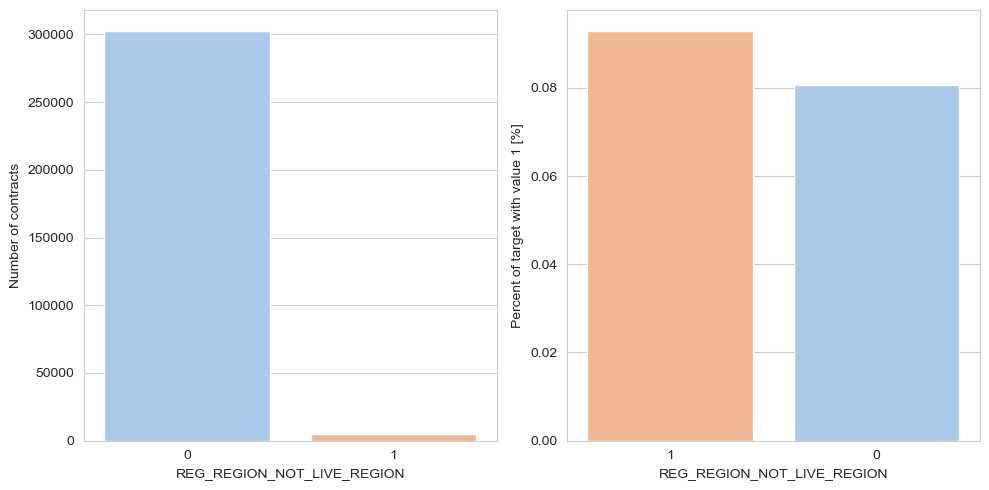

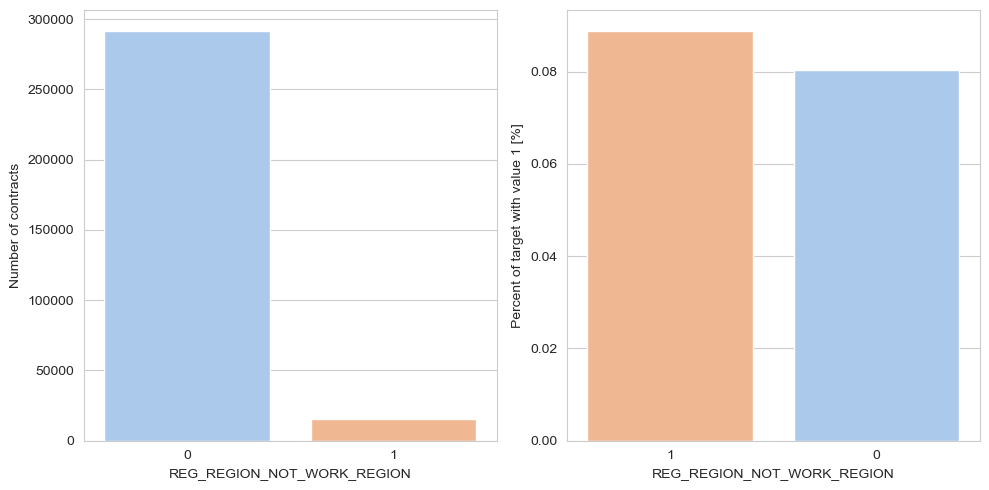

In [58]:
plot_stats('REG_REGION_NOT_LIVE_REGION')
plot_stats('REG_REGION_NOT_WORK_REGION')

Very few people are registered in not live or not work region. Generally, the rate of not return is slightly larger for these cases than in the rest (slightly above 8% compared with approx. 8%)

### City registered not live city and not work city

Let's represent the values of City registered not live city and not work city.

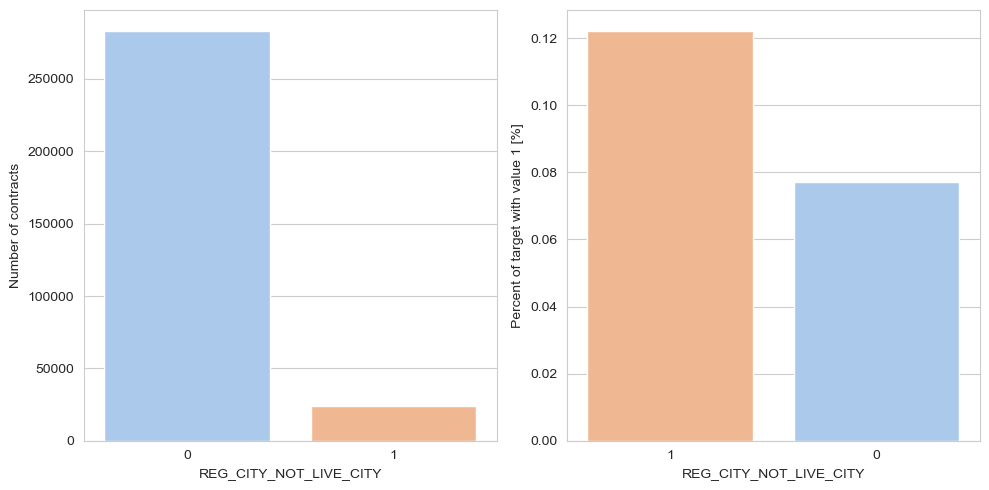

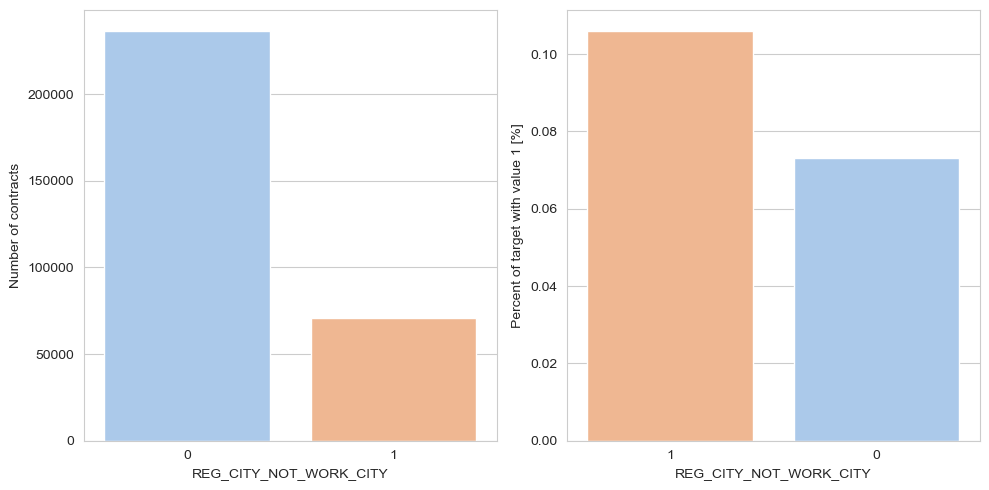

In [59]:
plot_stats('REG_CITY_NOT_LIVE_CITY')
plot_stats('REG_CITY_NOT_WORK_CITY')

Generally, much more people register in the city they live or work (a larger number register differently in the working city than living city).

The ones that register in different city than the working or living city are more frequently not-repaying the loans than the ones that register same city (work 11% or live 12%).

### Feature importance

#### Encoding Categorical Variables

Let's implement this policy : for any categorical variable (dtype == object) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding.

For label encoding, we use the Scikit-Learn LabelEncoder and for one-hot encoding, the pandas get_dummies(df) function.

In [60]:
app_train = application_train.copy()
app_test = application_test.copy()

In [61]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [62]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


In [63]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


#### Correlations with the target

In [64]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DAYS_REGISTRATION                                    0.041975
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

## Bureau data

Bureau data contains all client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in the sample). For every loan in the sample, there are as many rows as number of credits the client had in Credit Bureau before the application date. **SK_ID_CURR** is the key connecting *application_train*|*test* data with *bureau* data.

Let's merge *application_train* with *bureau*.

In [65]:
application_bureau_train = application_train.merge(bureau, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [66]:
print("The resulting dataframe `application_bureau_train` has ",application_bureau_train.shape[0]," rows and ", 
      application_bureau_train.shape[1]," columns.")

The resulting dataframe `application_bureau_train` has  1465325  rows and  138  columns.


Let's now analize the *application_bureau_train* data.

In [67]:
def plot_b_stats(feature, label_rotation=False, horizontal_layout=True):
    temp = application_bureau_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index, 'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = application_bureau_train[[feature, 'TARGET']].groupby([feature], as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)

    palette = sns.color_palette("pastel", len(df1))

    if horizontal_layout:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 10))

    # Barplot for number of contracts
    sns.barplot(ax=ax1, x=feature, y="Number of contracts", data=df1, palette=palette, hue=feature, legend=False)
    if label_rotation:
        ax1.set_xticks(range(len(df1)))
        ax1.set_xticklabels(df1[feature], rotation=90)

    # Barplot for percentage of target=1
    sns.barplot(ax=ax2, x=feature, y='TARGET', order=cat_perc[feature], data=cat_perc, palette=palette, hue=feature, legend=False)
    if label_rotation:
        ax2.set_xticks(range(len(cat_perc)))
        ax2.set_xticklabels(cat_perc[feature], rotation=90)
    
    ax2.set_ylabel('Percent of target with value 1 [%]', fontsize=10)
    ax2.tick_params(axis='both', which='major', labelsize=10)

    plt.tight_layout()
    plt.show()

### Credit status

Let's see the credit status distribution. We show first the number of credits per category (could be *Closed*, *Active*, *Sold* and *Bad debt*).

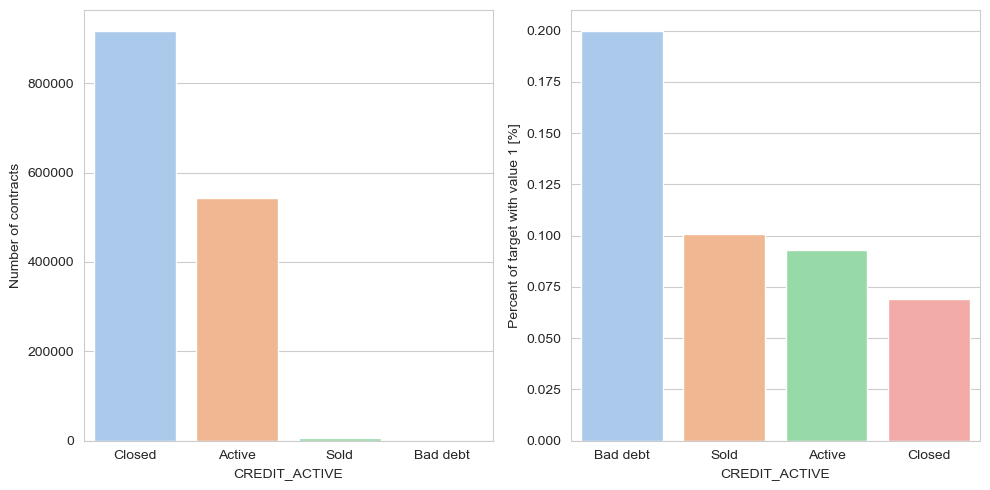

In [68]:
plot_b_stats('CREDIT_ACTIVE')

Most of the credits registered at the Credit Bureau are in the status *Closed* (~900K). On the second place are the *Active* credits ( a bit under 600K). *Sold* and *Bad debt* are just a few.

In the same time, as percent having **TARGET = 1** from total number per category, clients with credits registered to the Credit Bureau with *Bad debt* have 20%  default on the currrent applications. 


Clients with credits *Sold*, *Active* and *Closed* have percent of **TARGET == 1** (default credit) equal or less than 10% (10% being the rate overall). The smallest rate of default credit have the clients with credits registered at the Credit Bureau with *Closed* credits.

That means the former registered credit history (as registered at Credit Bureau) is a strong predictor for the dafault credit, since the percent of applications defaulting with a history of *Bad debt* is twice as large as for *Sold* or *Active* and almost three times larger as for *Closed*.

### Credit currency

Let's check now the number of credits registered at the Credit Bureau with different currencies. Also, let's check procent of defaulting credits (for current applications) per different currencies of credits credits registered at the Credit Bureau in the past for the same client.

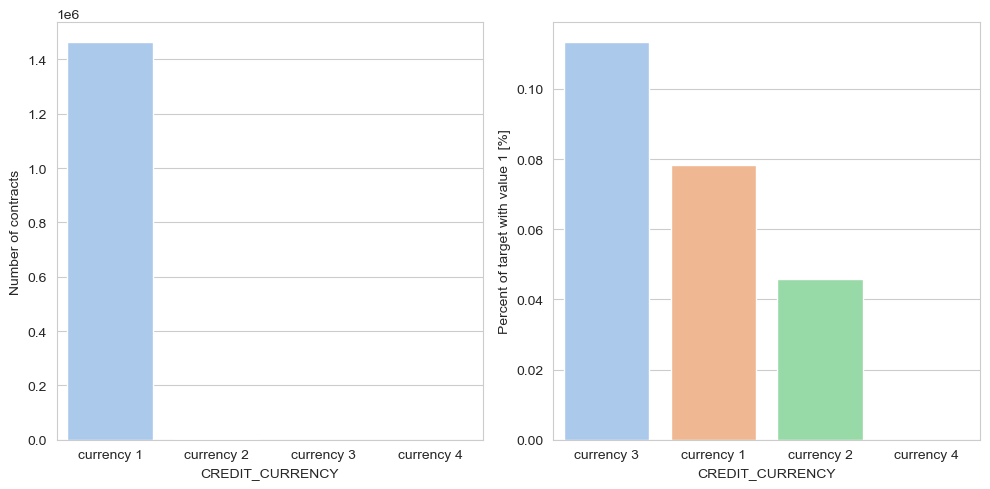

In [69]:
plot_b_stats('CREDIT_CURRENCY')

Credits are mostly in *currency_1*.

Depending on the currency, the percent of clients defaulting is quite different. Starting with *currency_3*, then *currency_1* and *currency_2*, the percent of clients defaulting is 11%, 8% and 5%. Percent of defaulting applications for clients that have credits registered with *currency_4* is close to 0.

### Credit type

Let's check now the credit types for credits registered at the Credit Bureau.

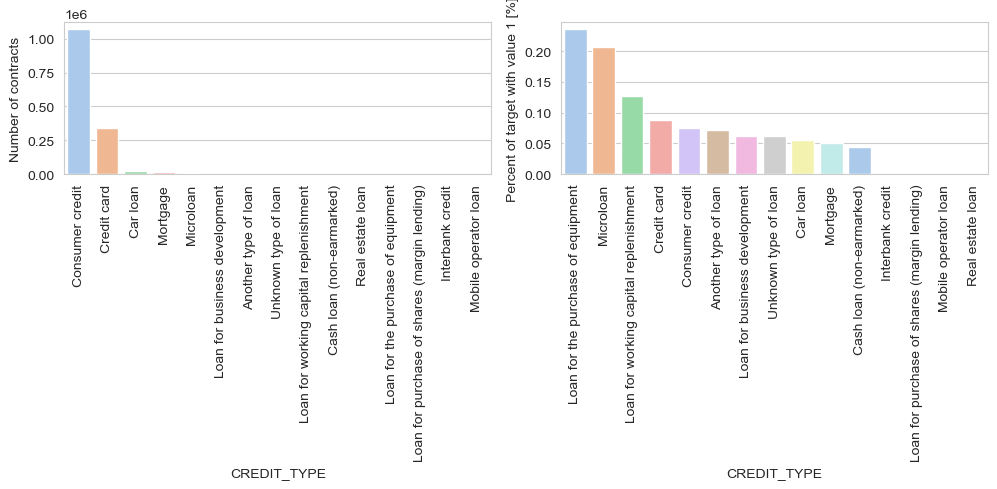

In [70]:
plot_b_stats('CREDIT_TYPE', True, True)

Majority of historical credits registered at the Credit Bureau are *Consumer credit* and *Credit card*. Smaller number of credits are *Car loan*, *Mortgage* and *Microloan*.

Looking now to the types of historical credits registered at the Credit Bureau, there are few types with a high percent of current credit defaults, as following:  
* *Loan for the purchase of equipment* - with over 20% current credits defaults;  
* *Microloan* - with over 20% current credits defaults;  
* *Loan for working capital replenishement* - with over 12% current credits defaults.  


### Duration of credit (DAYS_CREDIT)

Let's check the distribution of number of days for the credit (registered at the Credit bureau).


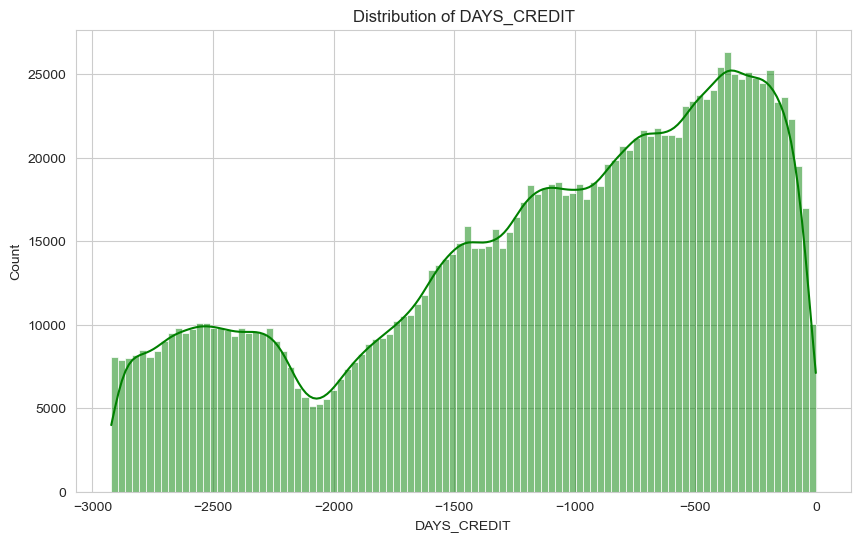

In [71]:
def plot_b_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    sns.histplot(application_bureau_train[feature].dropna(),color=color, kde=True,bins=100)
    plt.show() 
    
plot_b_distribution('DAYS_CREDIT','green')

The credit duration (in days) is ranging between less than 3000 days (with a local sadle around 2000 days) and with a increasing frequence for shorter number of days - and with a peak around 300 days (or less than one year).

### Credit overdue (CREDIT_DAY_OVERDUE)

Let's check the distribution of number of days for the credit overdue (registered at the Credit bureau).

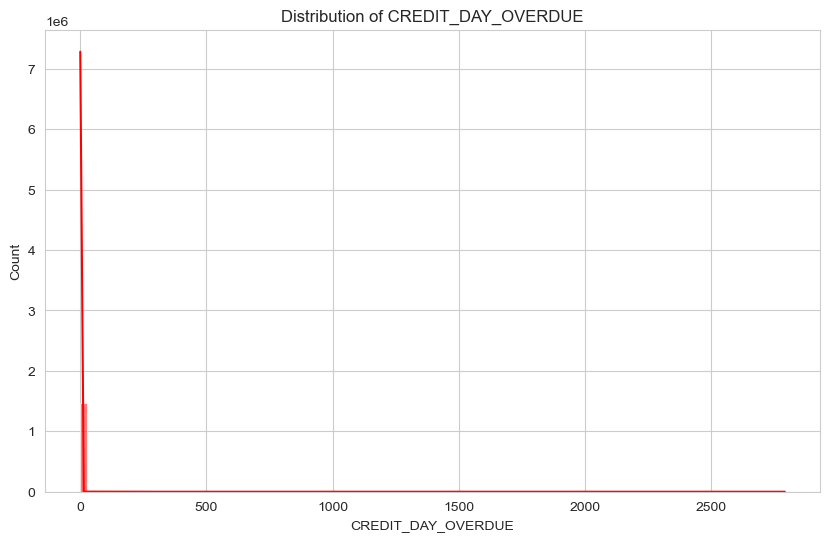

In [72]:
plot_b_distribution('CREDIT_DAY_OVERDUE','red')

Most of the credits have 0 or close to 0 days overdue. The maximum number of credit days overdue is ~3000 days.

### Credit sum  (AMT_CREDIT_SUM)

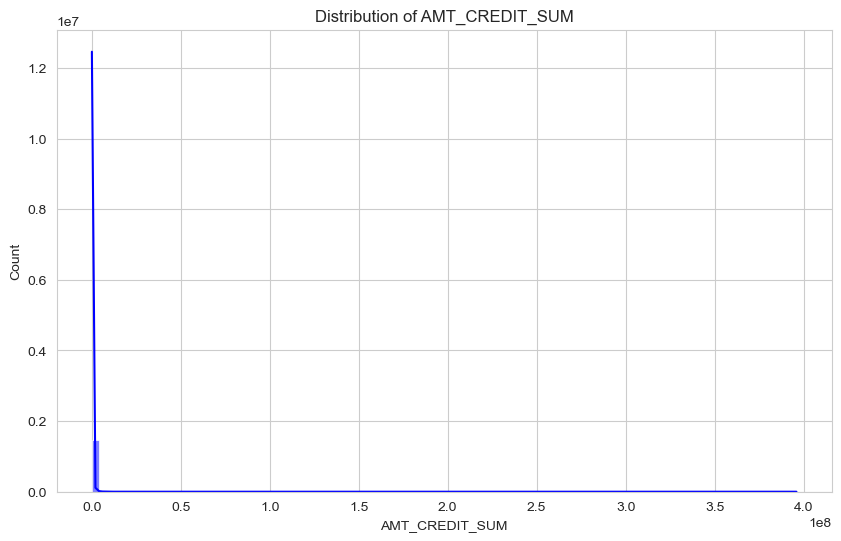

In [73]:
plot_b_distribution('AMT_CREDIT_SUM','blue')

The distribution of the AMT_CREDIT_SUM shows a concentration of the credits for the lower credit sum range.

Let's remove the outliers so that we can see better the distribution around 0.

Let's introduce a function to identify and filter the outliers (with a predefined threshold). 

Then, let's also modify the function to display a distribution, this time by using the function to filter the outliers.

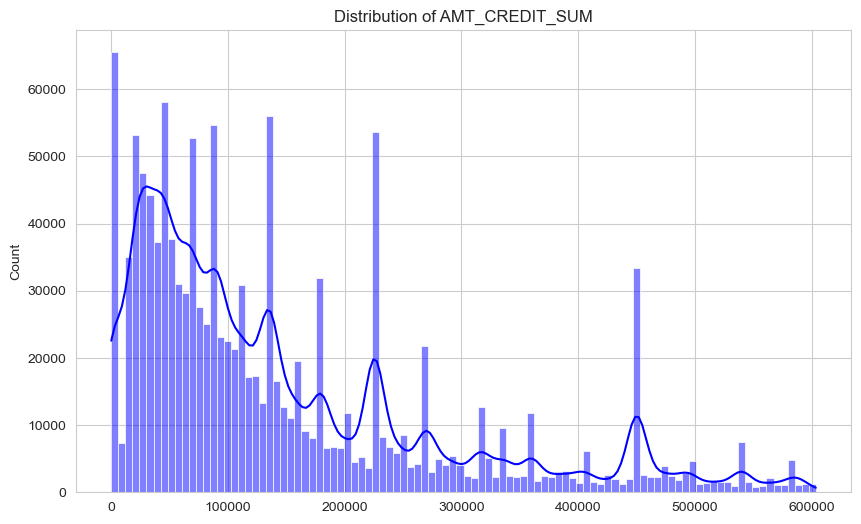

In [74]:
# Source: https://stackoverflow.com/questions/11882393/matplotlib-disregard-outliers-when-plotting (see references)

def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:, None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def plot_b_o_distribution(feature, color):
    plt.figure(figsize=(10, 6))
    plt.title("Distribution of %s" % feature)
    x = application_bureau_train[feature].dropna().values  
    filtered = x[~is_outlier(x)]
    sns.histplot(filtered, color=color, kde=True, bins=100)
    plt.show() 

plot_b_o_distribution('AMT_CREDIT_SUM', 'blue')


We can observe that the distribution function shows several peaks and the maximum concentration of the values is around 20,000 but we also see several other peaks at higher values.

### Credit sum limit (AMT_CREDIT_SUM_LIMIT)

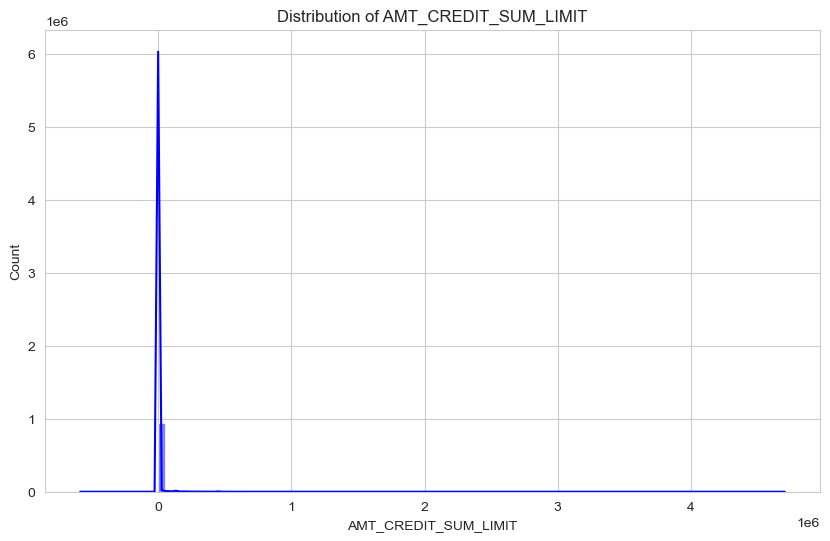

In [75]:
plot_b_distribution('AMT_CREDIT_SUM_LIMIT','blue')

### Comparison of interval values with TARGET = 1 and TARGET = 0

Let's compare the distribution of interval values ploted above for values of **TARGET = 1** and **TARGET = 0**

In [76]:
# Plot distribution of multiple features, with TARGET = 1/0 on the same graph
def plot_b_distribution_comp(var,nrow=2):
    
    i = 0
    t1 = application_bureau_train.loc[application_bureau_train['TARGET'] != 0]
    t0 = application_bureau_train.loc[application_bureau_train['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(t1[feature], bw_adjust=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw_adjust=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

<Figure size 640x480 with 0 Axes>

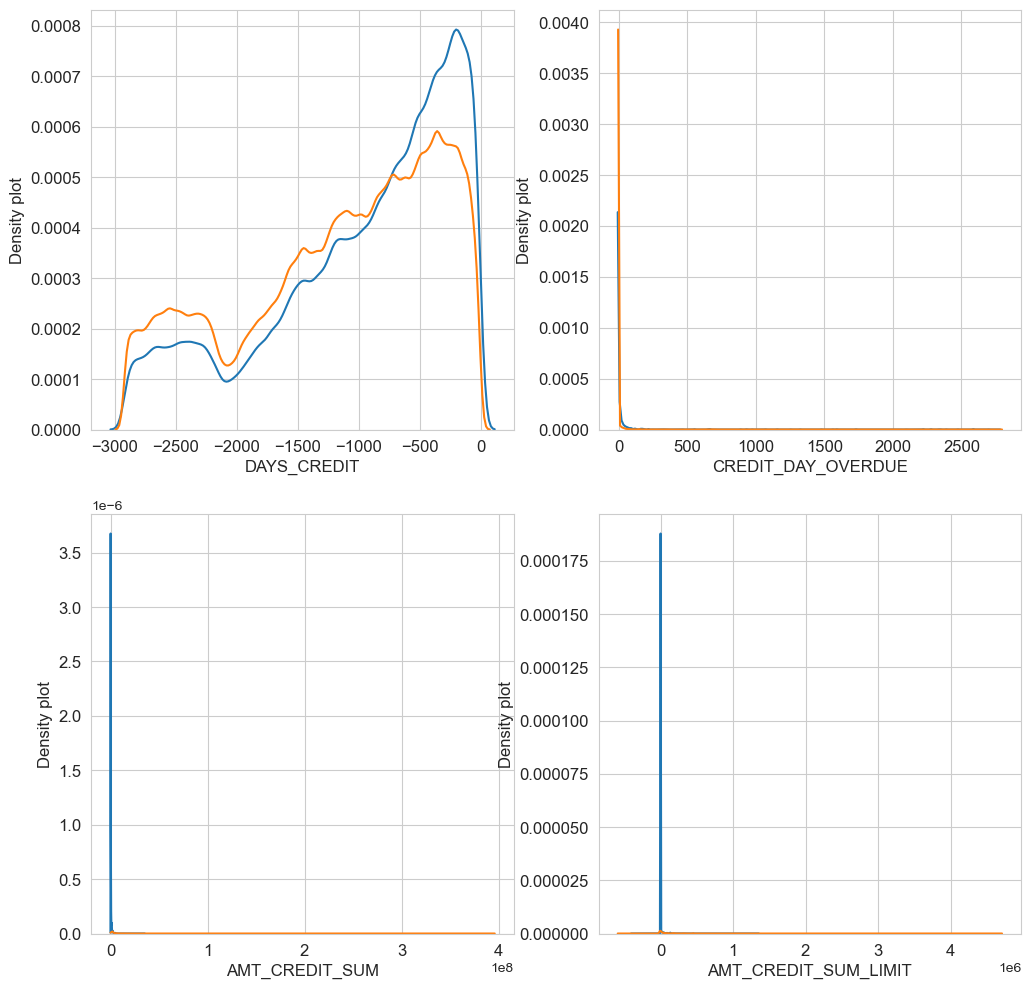

In [77]:
var = ['DAYS_CREDIT','CREDIT_DAY_OVERDUE','AMT_CREDIT_SUM','AMT_CREDIT_SUM_LIMIT']

plot_b_distribution_comp(var, nrow=2)

## Previous application data


The dataframe *previous_application* contains information about all previous applications for Home Credit loans of clients who have loans in the sample. There is one row for each previous application related to loans in our data sample. **SK_ID_CURR** is the key connecting *application_train*|*test* data with *previous_application* data.

Let's merge *application_train* with *previous_application*.

In [78]:
application_prev_train = application_train.merge(previous_application, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [79]:
print("The resulting dataframe `application_prev_train` has ",application_prev_train.shape[0]," rows and ", 
      application_prev_train.shape[1]," columns.")

The resulting dataframe `application_prev_train` has  1413701  rows and  158  columns.


In [80]:
def plot_p_stats(feature, label_rotation=False, horizontal_layout=True):
    temp = application_prev_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index, 'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = application_prev_train[[feature, 'TARGET']].groupby([feature], as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)

    palette = sns.color_palette("pastel", len(df1))

    if horizontal_layout:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 10))

    # Barplot for number of contracts
    sns.barplot(ax=ax1, x=feature, y="Number of contracts", data=df1, palette=palette, hue=feature, legend=False)
    if label_rotation:
        ax1.set_xticks(range(len(df1)))
        ax1.set_xticklabels(df1[feature], rotation=90)

    # Barplot for percentage of target=1
    sns.barplot(ax=ax2, x=feature, y='TARGET', order=cat_perc[feature], data=cat_perc, palette=palette, hue=feature, legend=False)
    if label_rotation:
        ax2.set_xticks(range(len(cat_perc)))
        ax2.set_xticklabels(cat_perc[feature], rotation=90)
    
    ax2.set_ylabel('Percent of target with value 1 [%]', fontsize=10)
    ax2.tick_params(axis='both', which='major', labelsize=10)

    plt.tight_layout()
    plt.show()

### Contract type

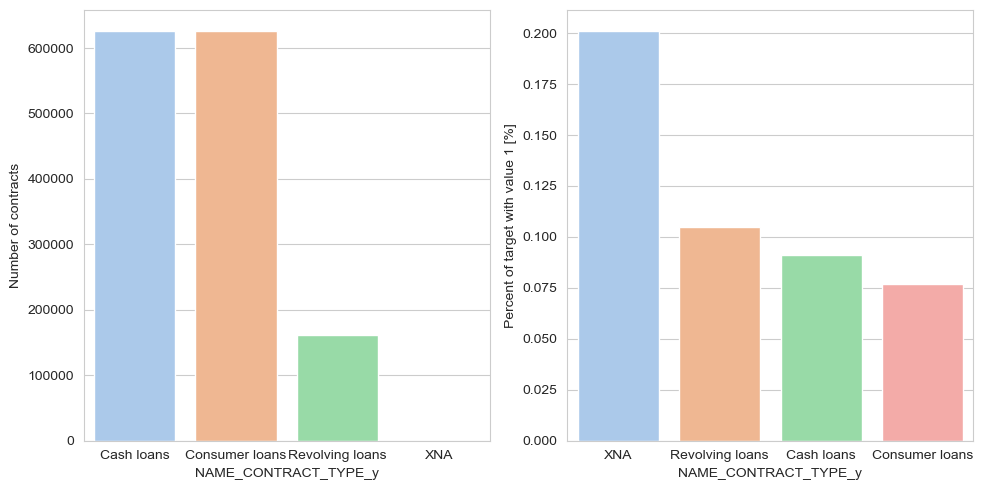

In [81]:
plot_p_stats('NAME_CONTRACT_TYPE_y')

There are three types of contract in the previous application data: *Cash loans*, *Consumer loans*, *Revolving loans*. *Cash loans* and *Consumer loans* are almost the same number (~600K) whilst *Revolving loans* are ~150K.

The percent of defauls loans for clients with previous applications is different for the type of previous applications contracts, decreasing from ~10% for *Revolving loans*, then ~ 9.5% for *Cash loans* and ~8% for *Consumer loans*.

### Cash loan purpose

Let's look to the cash loan purpose, in the case of cash loans.

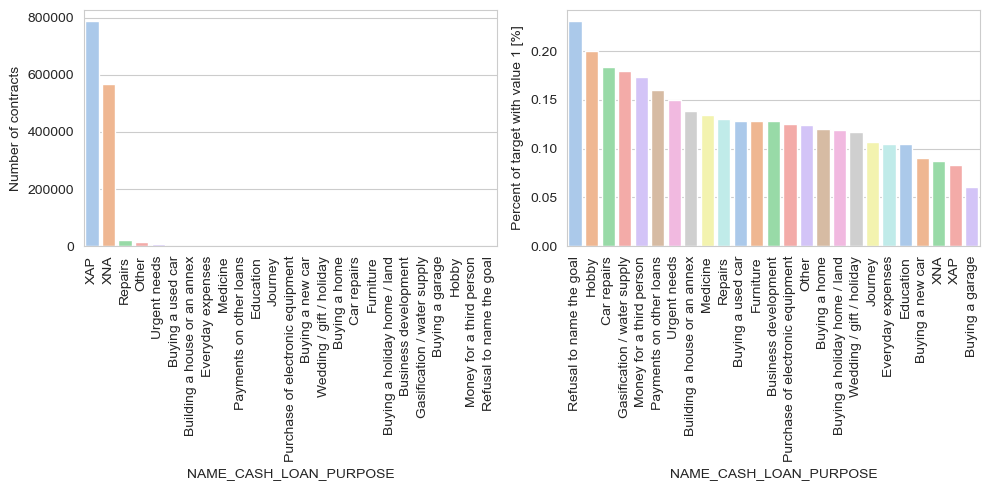

In [82]:
plot_p_stats('NAME_CASH_LOAN_PURPOSE', True, True)

Besides not identifed/not available categories, *Repairs*, *Other*, *Urgent needs*, *Buying a used car*, *Building a house or an annex* accounts for the largest number of contracts.


In terms of percent of defaults for current applications in the sample, clients with history of previous applications have largest percents of defaults when in their history are previous applications for cash loans for *Refusal to name the goal* - `~23%` (which makes a lot of sense), *Hobby* (`20%`), *Car repairs* (`~18%`).

### Contract status

Let's look to the contract status.

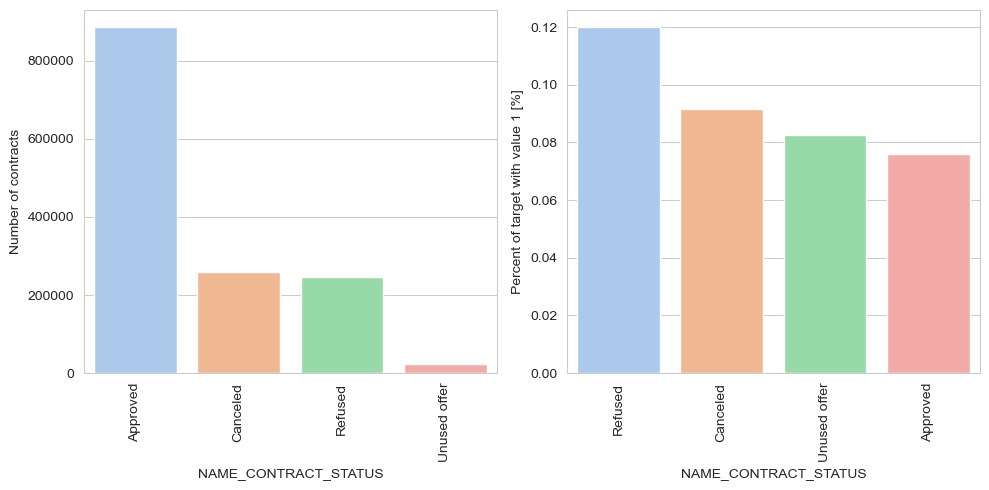

In [83]:
plot_p_stats('NAME_CONTRACT_STATUS', True, True)

Most previous applications contract statuses are *Approved* (`~850K`), *Canceled* and *Refused* (`~240K`). There are only `~20K` in status *Unused offer*.

In terms of percent of defaults for current applications in the sample, clients with history of previous applications have largest percents of defaults when in their history contract statuses are *Refused* (`12%`), followed by *Canceled* (`9%`), *Unused offer* (`~8%`) and *Approved* (lowest percent of defaults in current applictions, with less than `8%`).

### Payment type

Let's check the payment type.

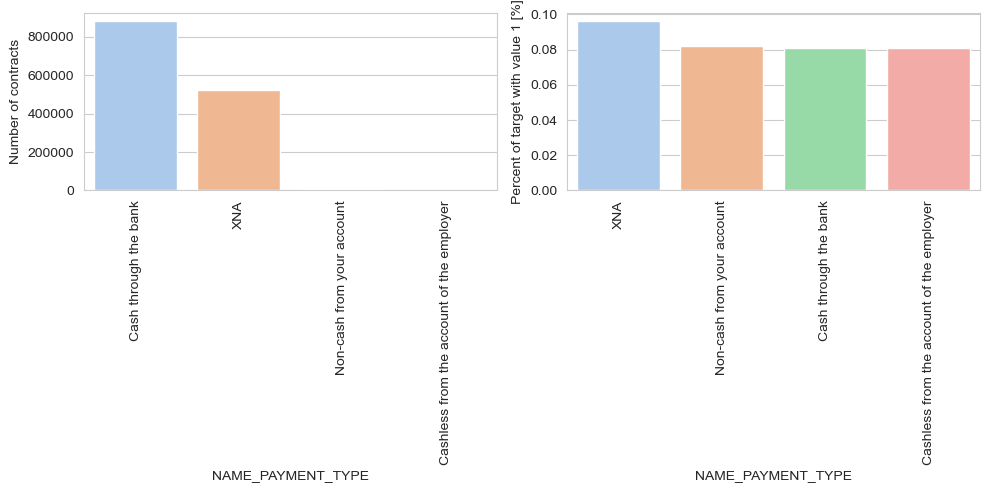

In [84]:
plot_p_stats('NAME_PAYMENT_TYPE', True, True)

Most of the previous applications were paid with *Cash through the bank* (`~850K`). Payments using *Non-cash from your account* or *Cashless from the account of the employer* are much rare. These three types of payments in previous applications results in allmost the same percent of defaults for current clients (`~8%` each).

### Client type

Let's check the client type for previous applications.

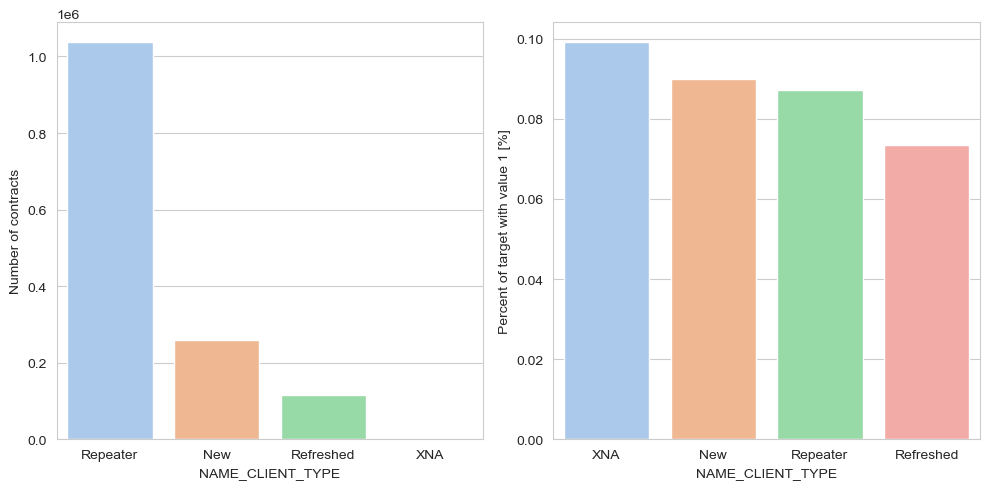

In [85]:
plot_p_stats('NAME_CLIENT_TYPE')

Most of the previous applications have client type *Repeater* (~1M), just over 200K are *New* and ~100K are *Refreshed*.

In terms of default percent for current applications of clients with history of previous applications, current clients with previous applications have values of percent of defaults ranging from from 8.5%, 8.25% and 7% corresponding to client types in the past *New*, *Repeater* and *Refreshed*, respectivelly.

### Previous application rejected reason

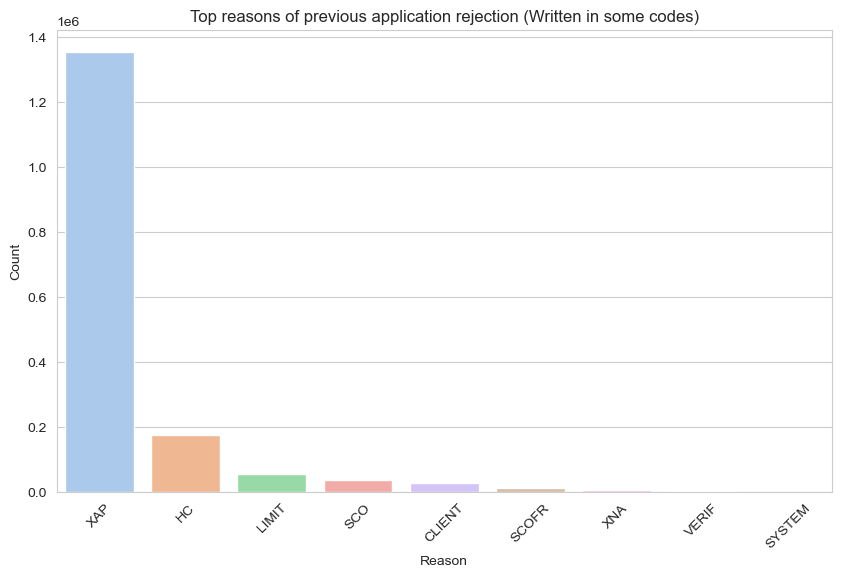

In [86]:
temp = previous_application["CODE_REJECT_REASON"].value_counts()
df = pd.DataFrame({'Reason': temp.index, 'Count': temp.values})

# Configuration de la figure
plt.figure(figsize=(10, 6))
plt.title('Top reasons of previous application rejection (Written in some codes)')
plt.xlabel('Reason')
plt.ylabel('Count')

# Création du graphique en barres
sns.barplot(x='Reason', y='Count', data=df, palette="pastel", hue='Reason')

# Rotation des labels si nécessaire
plt.xticks(rotation=45)

# Affichage
plt.show()